In [1]:
from model import *
from data import *
import matplotlib.pyplot as plt

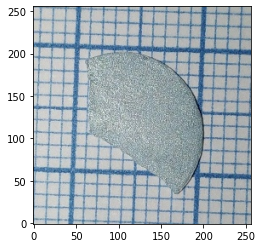

In [4]:
image, filename = by_id(278, name=True)
#image, filename = next(random_images(names=True))
img = rgb2gray(image)
plt.imshow(image, origin='lower')
plt.show()

# Transformação de Hough

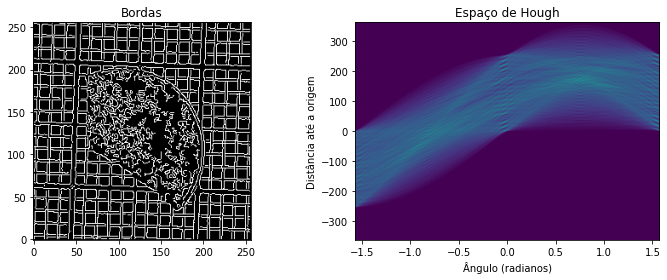

In [5]:
edges = canny(img)
hspace, angles, dists = hough_line(edges, np.linspace(-np.pi/2, np.pi/2, 500))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(edges, origin='lower', cmap='gray')
ax1.set_title('Bordas')
ax2.imshow(hspace, aspect='auto', origin='lower', extent=[angles.min(), angles.max(), dists.min(), dists.max()])
ax2.set_title('Espaço de Hough')
ax2.set_xlabel('Ângulo (radianos)')
ax2.set_ylabel('Distância até a origem')
plt.show()

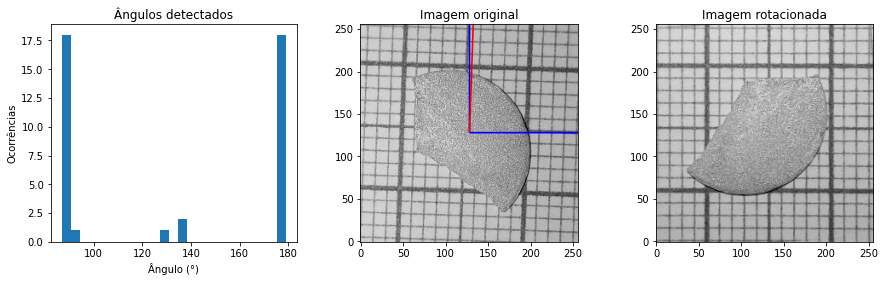

In [6]:
slopes = np.degrees(hough_line_peaks(hspace, angles, dists)[1]) + 90
img_slope = mode(slopes)[0][0]
rot_img = rotate(img, img_slope, mode='reflect')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.hist(slopes, bins=25)
ax1.set_title('Ângulos detectados')
ax1.set_xlabel('Ângulo (°)')
ax1.set_ylabel('Ocorrências')

ax2.imshow(img, cmap='gray', origin='lower')
ax2.set_title('Imagem original')
ax2.quiver(
    np.ones(3)*img.shape[1]/2, 
    np.ones(3)*img.shape[0]/2, 
    [1, 0, np.cos(np.radians(img_slope))], 
    [0, 1, np.sin(np.radians(img_slope))], 
    scale=1, color=['b', 'b', 'r']
)

ax3.imshow(rot_img, cmap='gray', origin='lower')
ax3.set_title('Imagem rotacionada')
plt.show()

# Detecção da escala

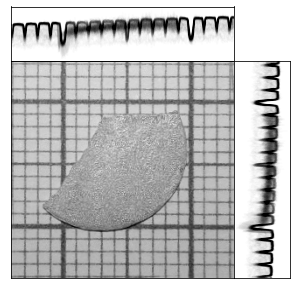

In [7]:
fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), wspace=0, hspace=0)

ax = fig.add_subplot(gs[1, 0])
ax_plotx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_plotx.set_xticks([])
ax_plotx.set_yticks([])
ax_ploty = fig.add_subplot(gs[1, 1], sharey=ax)
ax_ploty.set_xticks([])
ax_ploty.set_yticks([])

ax.imshow(rot_img, cmap='gray', aspect='auto', origin='lower')
ax_plotx.plot(rot_img, 'k-', alpha=0.01)
t = np.arange(rot_img.shape[0])
for col in rot_img.T: 
    ax_ploty.plot(col, t, 'k-', alpha=0.01)
plt.show()

## Transformação de Fourier

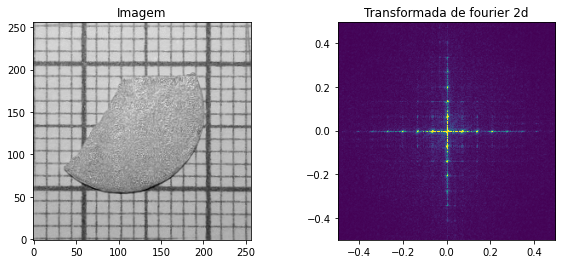

In [8]:
fft, xfreq, yfreq = fft2d(rot_img)
fft = np.abs(np.fft.fftshift(fft))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(rot_img, cmap='gray', origin='lower')
ax1.set_title('Imagem')
ax2.imshow(fft, vmax=fft.max()*0.007, extent=(xfreq.min(), xfreq.max(), yfreq.min(), yfreq.max()))
ax2.set_title('Transformada de fourier 2d')
plt.show()

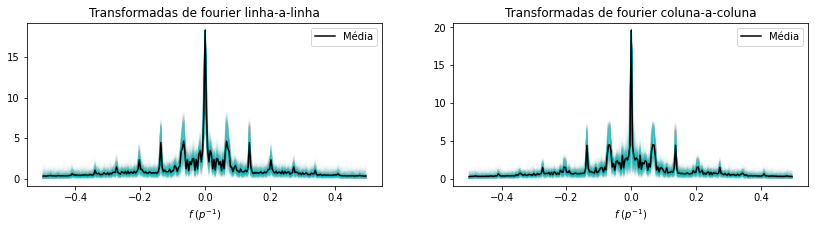

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))

xfft = np.fft.ifftshift(np.apply_along_axis(lambda x: fft1d(x)[0], 0, rot_img))
xfft_clipped = np.clip(xfft, 0, xfft.max()*0.1)
yfft = np.fft.ifftshift(np.apply_along_axis(lambda x: fft1d(x)[0], 1, rot_img))
yfft_clipped = np.clip(yfft, 0, yfft.max()*0.1)

ax1.plot(np.fft.ifftshift(xfreq), xfft_clipped,'c-', alpha=0.01)
ax1.plot(np.fft.ifftshift(xfreq), np.mean(xfft_clipped, axis=1), 'k-', label='Média')
ax1.set_title(r'Transformadas de fourier linha-a-linha')
ax1.set_xlabel(r'$f$ ($p^{-1}$)')
ax1.legend()

ax2.plot(np.fft.ifftshift(yfreq), yfft_clipped.T,'c-', alpha=0.01)
ax2.plot(np.fft.ifftshift(yfreq), np.mean(yfft_clipped, axis=0), 'k-', label='Média')
ax2.set_title(r'Transformadas de fourier coluna-a-coluna')
ax2.set_xlabel(r'$f$ ($p^{-1}$)')
ax2.legend()

plt.show()

0.0703125 0.0703125


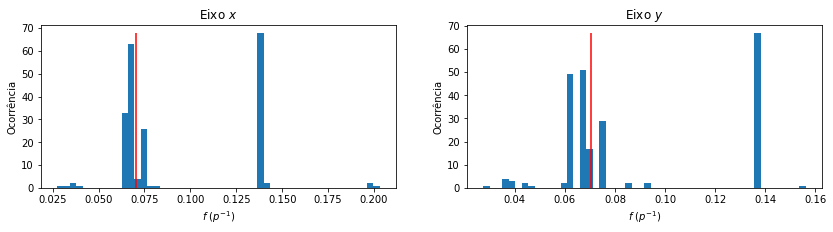

In [14]:
Fx = np.apply_along_axis(higher_frequency, 0, rot_img)
Fy = np.apply_along_axis(higher_frequency, 1, rot_img)

fx, fy = np.median(Fx[Fx > 0.025]), np.median(Fy[Fy > 0.025])
print(fx, fy)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))
hist, _, _ = ax1.hist(Fx[Fx > 0.025], bins=50)
ax1.vlines(fx, 0, hist.max(), color='r')
ax1.set_title(r'Eixo $x$')
ax1.set_xlabel(r'$f$ ($p^{-1}$)')
ax1.set_ylabel('Ocorrência')

hist, _, _ = ax2.hist(Fy[Fy > 0.025], bins=50)
ax2.vlines(fy, 0, hist.max(), color='r')
ax2.set_title(r'Eixo $y$')
ax2.set_xlabel(r'$f$ ($p^{-1}$)')
ax2.set_ylabel('Ocorrência')
plt.show()

# Filtros de Gabor

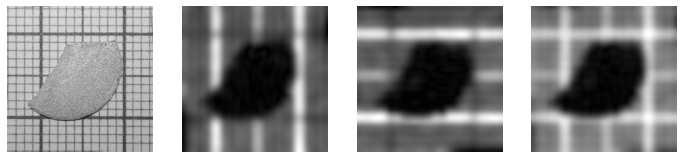

CPU times: total: 3.41 s
Wall time: 5.34 s


In [15]:
%%time
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))

xreal, ximag = gabor(rot_img, fx, 0, n_stds=3)
yreal, yimag = gabor(rot_img, fy, np.pi/2, n_stds=3)
gabor_x, gabor_y = np.sqrt(xreal**2 + ximag**2), np.sqrt(yreal**2 + yimag**2)
filtered = gabor_x + gabor_y

ax1.imshow(rot_img, cmap='gray', origin='lower')
ax2.imshow(gabor_x, cmap='gray', origin='lower')
ax3.imshow(gabor_y, cmap='gray', origin='lower')
ax4.imshow(filtered, cmap='gray', origin='lower')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

# Segmentação

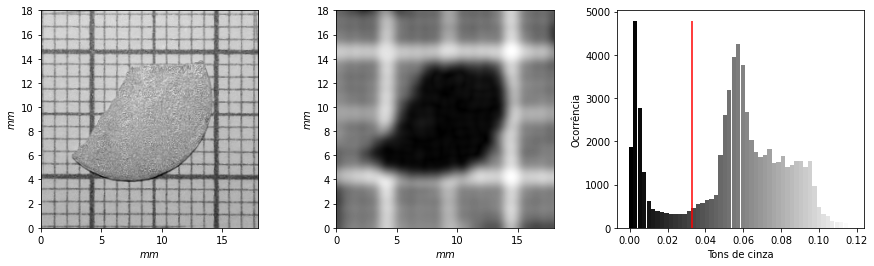

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

threshold = threshold_kmeans(filtered, 3, 50)

ax1.imshow(rot_img, extent=(0, fx*img.shape[1], 0, fy*img.shape[0]), origin='lower', cmap='gray')
ax1.set_xlabel(r'$mm$')
ax1.set_ylabel(r'$mm$')

ax2.imshow(filtered, extent=(0, fx*img.shape[1], 0, fy*img.shape[0]), origin='lower', cmap='gray')
ax2.set_xlabel(r'$mm$')
ax2.set_ylabel(r'$mm$')

hist, bins = np.histogram(filtered, bins=50)
bins = bins[:-1]
ax3.bar(bins, hist, (bins.max()-bins.min())/len(bins), 
        color=np.ones((len(bins), 3))*((bins - bins.min())/(bins.max() - bins.min()))[:, np.newaxis])
ax3.vlines(threshold, 0, hist.max(), color='red', label='Segmentação')
ax3.set_xlabel('Tons de cinza')
ax3.set_ylabel('Ocorrência')
        
plt.show()

# Predição

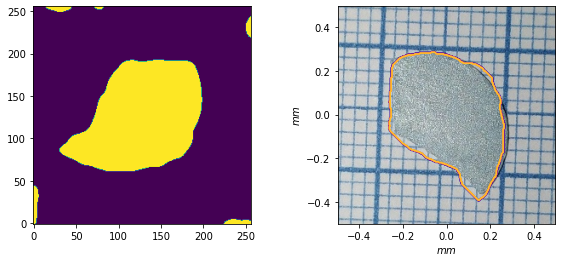

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

mask = filtered < threshold
ax1.imshow(mask, origin='lower')

mask = nd.binary_opening(mask, iterations=6)
mask = nd.binary_dilation(mask, iterations=2)

plt.imshow(image, origin='lower', extent=[xfreq.min(), xfreq.max(), yfreq.min(), yfreq.max()])
plt.contour(*np.meshgrid(np.fft.ifftshift(xfreq), np.fft.ifftshift(yfreq)), 
            rotate(mask, -img_slope), cmap='plasma', origin='lower')
plt.xlabel(r'$mm$')
plt.ylabel(r'$mm$')
plt.show()

In [18]:
predict = np.sum(mask)*fx*fy
area = float(DS.loc[DS.filename == filename].area)
print(f'Valor real: {area} mm')
print(f'Valor encontrado: {predict:.3f} mm')
print(f'Erro relativo: {np.abs(area-predict)/area*100:.3f}%') 

Valor real: 72.712 mm
Valor encontrado: 75.290 mm
Erro relativo: 3.545%


# Filtros de Gabor nas diagonais

In [19]:
real45, imag45 = gabor(rot_img, np.sqrt(fx**2 + fy**2), np.pi/4, n_stds=3)
gabor45 = np.sqrt(real45**2 + imag45**2)

real135, imag135 = gabor(rot_img, np.sqrt(fx**2 + fy**2), np.pi/4 + np.pi/2, n_stds=3)
gabor135 = np.sqrt(real135**2 + imag135**2)

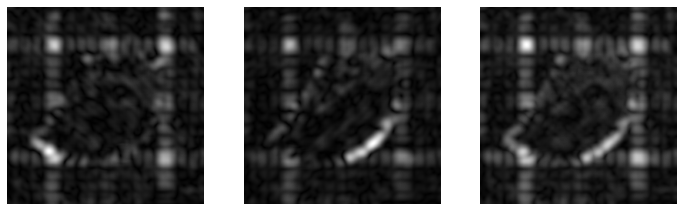

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(gabor45, cmap='gray', origin='lower')
ax2.imshow(gabor135, cmap='gray', origin='lower')
ax3.imshow(gabor45 + gabor135, cmap='gray', origin='lower')

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

plt.show()

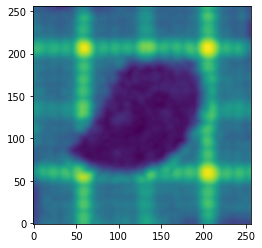

In [21]:
filtered2 = filtered + gabor45 + gabor135
plt.imshow(filtered2, origin='lower')

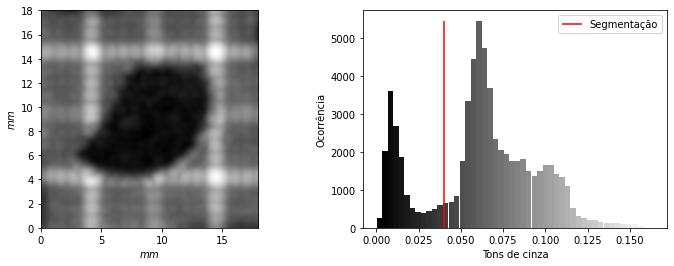

In [22]:
threshold = threshold_kmeans(filtered2, 3, 50)
hist, bins = np.histogram(filtered2.flat, bins=50)
bins = bins[:-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.imshow(filtered2, extent=(0, fx*img.shape[1], 0, fy*img.shape[0]), origin='lower', cmap='gray')
ax1.set_xlabel(r'$mm$')
ax1.set_ylabel(r'$mm$')

ax2.bar(bins, hist, (bins.max()-bins.min())/len(bins), 
        color=np.ones((len(bins), 3))*((bins - bins.min())/(bins.max() - bins.min()))[:, np.newaxis])
ax2.vlines(threshold, 0, hist.max(), color='red', label='Segmentação')
ax2.set_xlabel('Tons de cinza')
ax2.set_ylabel('Ocorrência')
ax2.legend()

plt.show()

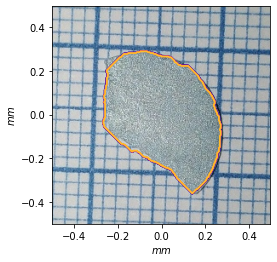

In [28]:
mask2 = filtered2 < threshold
mask2 = nd.binary_opening(mask2, iterations=10)
mask2 = nd.binary_dilation(mask2, iterations=5)

plt.imshow(image, origin='lower', extent=[xfreq.min(), xfreq.max(), yfreq.min(), yfreq.max()])
plt.contour(*np.meshgrid(np.fft.ifftshift(xfreq), np.fft.ifftshift(yfreq)), 
            rotate(mask2, -img_slope), cmap='plasma', origin='lower')
plt.xlabel(r'$mm$')
plt.ylabel(r'$mm$')
plt.show()

In [24]:
predict = np.sum(mask2)*fy*fx
area = float(DS.loc[DS.filename == filename].area)
print(f'Valor real: {area} mm')
print(f'Valor encontrado: {predict:.3f} mm')
print(f'Erro relativo: {np.abs(area-predict)/area*100:.3f}%') 

Valor real: 72.712 mm
Valor encontrado: 76.427 mm
Erro relativo: 5.109%


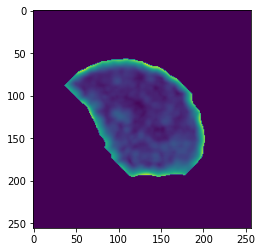

In [25]:
plt.imshow(mask2*filtered2)

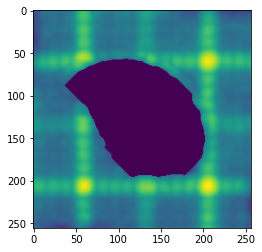

In [26]:
plt.imshow(np.logical_not(mask2)*filtered2)

In [27]:
np.sum(mask2*filtered2) + np.sum(np.logical_not(mask2)*filtered2)

4224.455635866507

# Testes

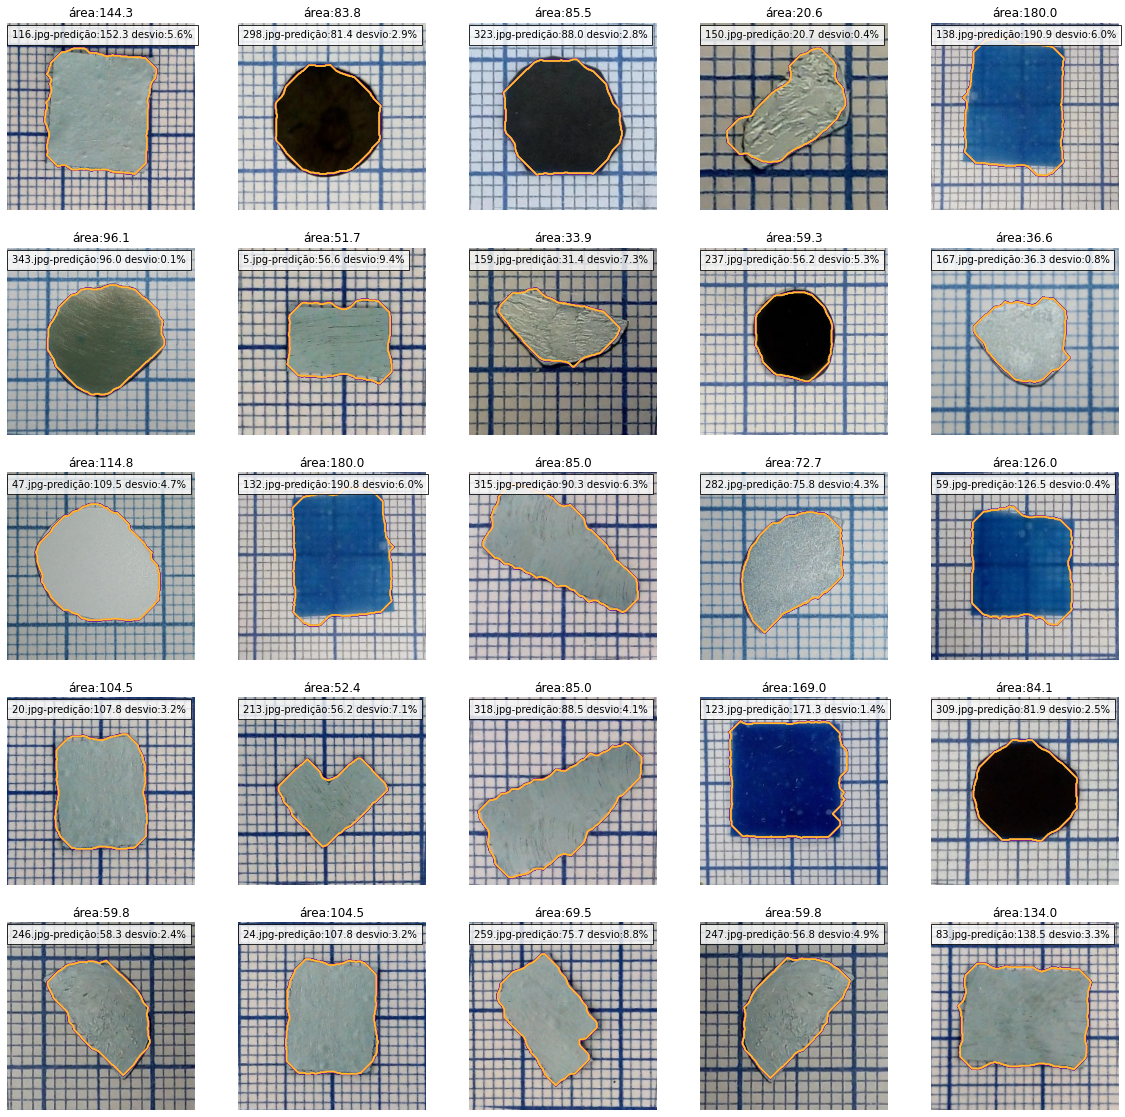

In [30]:
n = 5
r = 5
fig, axs = plt.subplots(r, n, figsize=(4*n, 4*r))
axs = axs.flatten()

for i, (image, name) in enumerate(random_images(r*n, names=True)):
    #print(name, end=', ')
    
    img = rgb2gray(image)
    
    edges = canny(img)
    hspace, angles, dists = hough_line(edges, np.linspace(-np.pi/2, np.pi/2, 500))
    slopes = np.degrees(hough_line_peaks(hspace, angles, dists)[1]) + 90
    img_slope = mode(slopes)[0][0]
    rot_img = rotate(img, img_slope, mode='reflect')
    
    Fx = np.apply_along_axis(higher_frequency, 0, rot_img)
    Fy = np.apply_along_axis(higher_frequency, 1, rot_img)

    fx, fy = np.median(Fx[Fx > 0.025]), np.median(Fy[Fy > 0.025])
    
    xreal, ximag = gabor(rot_img, fx, 0, n_stds=3)
    yreal, yimag = gabor(rot_img, fy, np.pi/2, n_stds=3)
    gabor_x, gabor_y = np.sqrt(xreal**2 + ximag**2), np.sqrt(yreal**2 + yimag**2)
    real45, imag45 = gabor(rot_img, np.sqrt(fx**2 + fy**2), np.pi/4, n_stds=3)
    real135, imag135 = gabor(rot_img, np.sqrt(fx**2 + fy**2), np.pi/4 + np.pi/2, n_stds=3)
    gabor45 = np.sqrt(real45**2 + imag45**2)
    gabor135 = np.sqrt(real135**2 + imag135**2)
    filtered = gabor_x + gabor_y + gabor45 + gabor135
    
    threshold = threshold_kmeans(filtered, 3, 50)
    mask = filtered < threshold
    mask = nd.binary_opening(mask, iterations=10)
    mask = nd.binary_dilation(mask, iterations=5)
    
    axs[i].imshow(rotate(image, img_slope, mode='reflect'))
    axs[i].contour(mask, cmap='plasma')
    
    area = float(DS.loc[DS.filename == name].area)
    area_pixel = np.sum(mask)
    predict = area_pixel*fx*fy
    
    axs[i].set_title(f'área:{area:.1f}')
    axs[i].text(6, 20, '{c}-predição:{p:.1f} desvio:{d:.1f}%'.format(c=name, p=predict, d=(np.abs(area-predict)/area*100)),
               bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
    axs[i].axis('off')
    #axs[i].legend()
    
plt.show()